In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
from tqdm import *

import sys
sys.path.insert(0, '../')

# tells which GPU to use.
os.environ["CUDA_VISIBLE_DEVICES"]="0"

np.random.seed(1017)
random.seed(1017)

import scipy.sparse as sp

import torch
from torch.utils.data import Dataset, DataLoader

#from egexplainer import AttributionPriorExplainer

# Build Data

In [2]:
class ExVivoDrugData(Dataset):
    
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.y is not None:
            return sample, self.y[index]
        else:
            return sample

In [3]:
# load data
DATADIR = '/fdata/ohsu_data/'

X_rna_seq = pickle.load(open(DATADIR + 'X_rna_seq.p','rb'))
X_rna_seq = X_rna_seq.loc[:,~X_rna_seq.columns.duplicated()]
X_drug_labels = pickle.load(open(DATADIR + 'X_drug_labels.p','rb'))
final_frame = pickle.load(open(DATADIR + 'final_frame.p','rb'))

In [4]:
X = pd.concat([X_drug_labels,X_rna_seq],axis=1)
y = final_frame.IC50

### We select only the genes that overlap with the MERGE score data

In [5]:
import pandas as pd

merge_df = pd.read_csv("data/merge_features.csv")

merge_df = merge_df.transpose()
new_header = merge_df.iloc[0] #grab the first row for the header
merge_df = merge_df[1:] #take the data less the header row
merge_df.columns = new_header #set the header row as the df header
merge_df = merge_df.astype(float)

In [41]:
merge_df = pd.read_csv("data/merge_features.csv")

merge_df = merge_df.transpose()
new_header = merge_df.iloc[0] #grab the first row for the header
merge_df = merge_df[1:] #take the data less the header row
merge_df.columns = new_header #set the header row as the df header
merge_df = merge_df.astype(float)

In [45]:
overlapping_genes = list(set(merge_df.columns).intersection(X.columns))
drug_columns = [col for col in X.columns if 'drug_' in col]
merge_df = merge_df[overlapping_genes]


X = X[drug_columns + overlapping_genes]

In [7]:
# patient split

test_patients = random.sample(set(final_frame.patient_id),int(.2*len(set(final_frame.patient_id))))
train_patients = [x for x in set(final_frame.patient_id) if x not in test_patients]
val_patients = random.sample(train_patients,int(.2*len(train_patients)))
tr_patients = [x for x in train_patients if x not in val_patients]

tr_slice = final_frame.patient_id.isin(tr_patients)
val_slice = final_frame.patient_id.isin(val_patients)
train_slice = final_frame.patient_id.isin(train_patients)
test_slice = final_frame.patient_id.isin(test_patients)

X_tr = X.loc[tr_slice,:]
X_val = X.loc[val_slice,:]
y_tr = y[tr_slice]
y_val = y[val_slice]
X_train = X.loc[train_slice,:]
X_test = X.loc[test_slice,:]
y_train = y[train_slice]
y_test = y[test_slice]

train_frame = final_frame[train_slice]
test_frame = final_frame[test_slice]

In [8]:
feature_scaler = StandardScaler()
outcome_scaler = StandardScaler()

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

feature_scaler.fit(X_train)
outcome_scaler.fit(y_train)

X_train_ss,X_test_ss = feature_scaler.transform(X_train),feature_scaler.transform(X_test)
y_train_ss,y_test_ss = outcome_scaler.transform(y_train),outcome_scaler.transform(y_test)

In [9]:
feature_scaler = StandardScaler()
outcome_scaler = StandardScaler()

y_tr = y_tr.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

feature_scaler.fit(X_tr)
outcome_scaler.fit(y_tr)

X_tr_ss,X_val_ss = feature_scaler.transform(X_tr),feature_scaler.transform(X_val)
y_tr_ss,y_val_ss = outcome_scaler.transform(y_tr),outcome_scaler.transform(y_val)

In [51]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, H2, D_out = 32*2*2, X_tr_ss.shape[1], 512, 256, 1

# Create random Tensors to hold inputs and outputs
train_dataset = ExVivoDrugData(X_tr_ss,y_tr_ss)
test_dataset = ExVivoDrugData(X_val_ss,y_val_ss)

train_loader = DataLoader(dataset=train_dataset, batch_size=32*2*2, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32*2*2, shuffle=False,drop_last=False)

# build model

In [52]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
                    torch.nn.Linear(D_in, H1),
                    torch.nn.ReLU(),
                    torch.nn.Linear(H1, H2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(H2, D_out),
                )
    def forward(self, x):
        x = self.layers(x)
        return x

In [57]:
model = MLP().cuda().float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
mse_term = torch.nn.MSELoss()

mean_train_losses = []
mean_valid_losses = []
epochs = 60
fine_tuning_epochs = 5

for epoch in range(epochs):

    model.train()

    train_losses = []
    valid_losses = []

    # train
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.cuda().float(), labels.cuda().float()
        optimizer.zero_grad()

        outputs = model(features)
        loss = mse_term(outputs, labels) + 0.001*(torch.norm(model.layers[0].weight, p=1) + torch.norm(model.layers[2].weight, p=1) + torch.norm(model.layers[4].weight, p=1))
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.item())

    # valid
    for i, (features,labels) in enumerate(test_loader):
        features, labels = features.cuda().float(), labels.cuda().float()
        outputs = model(features)
        valid_losses.append(mse_term(outputs,labels).detach().cpu().numpy())

    print(epoch,np.mean(train_losses),np.mean(valid_losses))

0 30.097845889676 0.9781089
1 23.453437165291078 0.97163
2 17.781315951193534 0.9565504
3 13.092821016619283 0.9429279
4 9.404345518542874 0.93471
5 6.71321136413082 0.92278546
6 4.996638599518807 0.91784036
7 4.046754637072163 0.9042604
8 3.482655671335036 0.88380575
9 3.096056136777324 0.8587538
10 2.8060433126265 0.83693427
11 2.5731634339978617 0.8094802
12 2.381631975789224 0.78150254
13 2.2059229820005357 0.7389201
14 2.046624901217799 0.73838276
15 1.9066164539706323 0.69483495
16 1.7785145351963658 0.6942526
17 1.6628536555074875 0.66199815
18 1.546598510588369 0.6441847
19 1.4463922592901415 0.63735026
20 1.3622768732809252 0.6382437
21 1.2757993690429195 0.62389886
22 1.2087218161552182 0.62719977
23 1.133493624964068 0.6159318
24 1.0709042860615638 0.6217152
25 1.0136010027700855 0.62911206
26 0.9716288655034957 0.62144464
27 0.9307986247924066 0.6011634
28 0.8963447970728721 0.6120373
29 0.8667679171408377 0.6044698
30 0.842626465136005 0.60674787
31 0.8242957526637662 0.61

In [74]:
import shap

background = torch.FloatTensor(X_train.sample(100).values).cuda()
e = shap.GradientExplainer(model, background) 

In [75]:
test_examples_no_drugs = X_test.drop(drug_columns, axis=1)

In [76]:
shap_values = e.shap_values(torch.FloatTensor(X_test.values).cuda())
shap_values_no_drugs = shap_values[:,len(drug_columns):]

In [77]:
shap_avgs = np.absolute(shap_values_no_drugs).mean(axis=0).reshape(-1)

In [78]:
import matplotlib.pyplot as plt

np.corrcoef(merge_df.loc['Expression hub'], shap_avgs)

array([[ 1.        , -0.00546945],
       [-0.00546945,  1.        ]])

In [79]:
np.corrcoef(shap_avgs, merge_df.loc['Regulator'])

array([[ 1.        , -0.01144115],
       [-0.01144115,  1.        ]])

In [80]:
np.corrcoef(shap_avgs, merge_df.loc['Mutation'])

array([[ 1.       , -0.0044116],
       [-0.0044116,  1.       ]])

In [81]:
np.corrcoef(shap_avgs, merge_df.loc['Genomic abnormalities (CNV)'])


array([[1.        , 0.00217441],
       [0.00217441, 1.        ]])

In [82]:
np.corrcoef(shap_avgs, merge_df.loc['meEthylation'])

array([[1.        , 0.00833891],
       [0.00833891, 1.        ]])

In [83]:
np.corrcoef(shap_avgs, merge_df.loc['SCORE'])

array([[ 1.        , -0.00983662],
       [-0.00983662,  1.        ]])

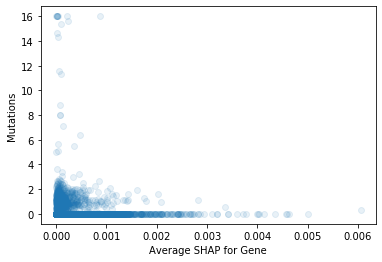

In [84]:
plt.plot(shap_avgs, merge_df.loc['Mutation'], 'o', alpha=0.1)
plt.xlabel("Average SHAP for Gene")
plt.ylabel("Mutations")
plt.show()

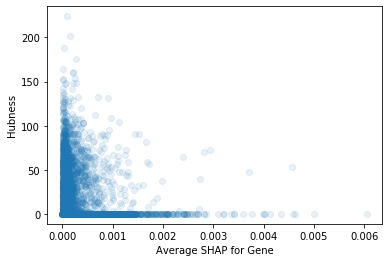

In [85]:
plt.plot(shap_avgs, merge_df.loc['Expression hub'], 'o', alpha=0.1)
plt.xlabel("Average SHAP for Gene")
plt.ylabel("Hubness")
plt.show()

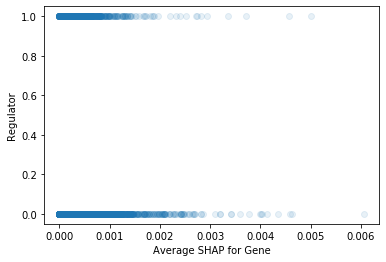

In [86]:
plt.plot(shap_avgs, merge_df.loc['Regulator'], 'o', alpha=0.1)
plt.xlabel("Average SHAP for Gene")
plt.ylabel("Regulator")
plt.show()

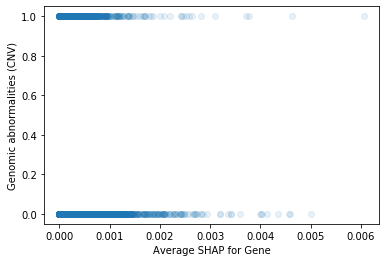

In [87]:
plt.plot(shap_avgs, merge_df.loc['Genomic abnormalities (CNV)'], 'o', alpha=0.1)
plt.xlabel("Average SHAP for Gene")
plt.ylabel("Genomic abnormalities (CNV)")
plt.show()

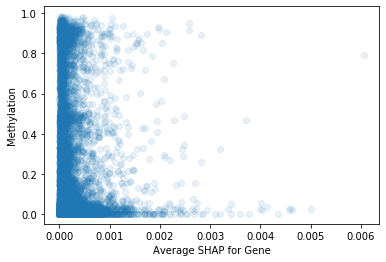

In [88]:
plt.plot(shap_avgs, merge_df.loc['meEthylation'], 'o', alpha=0.1)
plt.xlabel("Average SHAP for Gene")
plt.ylabel("Methylation")
plt.show()

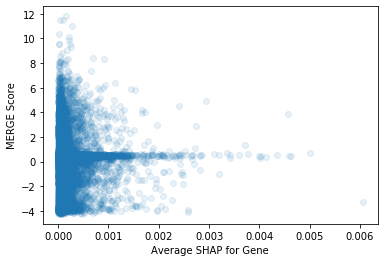

In [89]:
plt.plot(shap_avgs, merge_df.loc['SCORE'], 'o', alpha=0.1)
plt.xlabel("Average SHAP for Gene")
plt.ylabel("MERGE Score")
plt.show()